In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, plot_precision_recall_curve
from sklearn.model_selection import train_test_split

In [9]:
abo_path = 'D:/Users/masoodw/ML_FINANCE/asigmo/github/asigmo/data/telcom_churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
p_df_raw = pd.read_csv(abo_path, sep=',', encoding="UTF-8")

In [10]:
p_df_raw.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [11]:
p_df_raw.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [12]:
#p_df_raw.fillna(-1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Transform the data: make every column into number and scale the values of each column

In [15]:
df_y = p_df_raw['Churn']
df_y = pd.DataFrame(LabelEncoder().fit_transform(df_y))
df_y = df_y.reset_index(drop=True)

df_X_raw = p_df_raw.drop(['customerID', 'Churn'], axis=1)
#df_X_raw = p_df_raw_train.drop(['Name'], axis=1)

columns=df_X_raw.columns
for f in df_X_raw.columns:
    if df_X_raw[f].dtype == 'object':
        df_X_raw[f] = LabelEncoder().fit_transform(list(df_X_raw[f]))        

In [16]:
scaler = PowerTransformer()
scaled_df = scaler.fit_transform(df_X_raw)
df_X = pd.DataFrame(scaled_df, columns=columns)
df_X = df_X.reset_index(drop=True)

In [17]:
class_labels = np.unique(df_y)
class_weights = compute_class_weight('balanced', class_labels, df_y)
class_weights = dict(zip(class_labels, class_weights))

c:\programdata\anaconda3\envs\asigmo\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=      0
0     0
1     0
2     1
3     0
4     1
...  ..
7038  0
7039  0
7040  0
7041  1
7042  0

[7043 rows x 1 columns] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
c:\programdata\anaconda3\envs\asigmo\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [153]:
class_weights

{0: 0.6806146115191342, 1: 1.8841626538255751}

In [154]:
df_X.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [155]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y)

### Random Forest initializer

In [156]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

### training with CV

In [157]:
train_auc_list = []
valid_auc_list = []

fprs, tprs, scores = [], [], []

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)


for train_index, val_index in cv.split(X_train, y_train):
    X_train_sub, X_valid_sub = X_train.loc[X_train.index[train_index]], X_train.loc[X_train.index[val_index]]
    y_train_sub, y_valid_sub = y_train.loc[y_train.index[train_index]], y_train.loc[y_train.index[val_index]]
    
    clf.fit(X_train_sub, y_train_sub)
    clf_pred_train = clf.predict(X_train_sub)
    clf_pred_val = clf.predict(X_valid_sub)
            
    train_f1 = round(f1_score(clf_pred_train, y_train_sub), 8)*100
    valid_f1 = round(f1_score(clf_pred_val, y_valid_sub), 8)*100
        
    scores.append((train_f1, valid_f1))   
    train_auc_list.append(train_auc)
    valid_auc_list.append(valid_auc)
                

c:\programdata\anaconda3\envs\asigmo\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
c:\programdata\anaconda3\envs\asigmo\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
c:\programdata\anaconda3\envs\asigmo\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
c:\programdata\anaconda3\envs\asigmo\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

In [158]:
pd.DataFrame(scores, columns=['F1 Train', 'F1 Val'])

F1 Train     F1 Val
0  64.216366  65.063649
1  64.681149  63.442390
2  65.108165  64.388962
3  65.448155  62.745098
4  65.005192  59.826590

### Predicting on test data

In [159]:
clf_test_pred = clf.predict(X_test)

In [167]:
auc_test = roc_auc_score(y_test, clf_test_pred)
test_f1 = round(f1_score(y_test, clf_test_pred), 8)*100
print('\nAUROC:',auc_test, ", F1 score:", test_f1)


AUROC: 0.7417196007259528 , F1 score: 59.719789999999996


In [161]:
fpr, tpr, threshold = roc_curve(y_test, clf_test_pred)

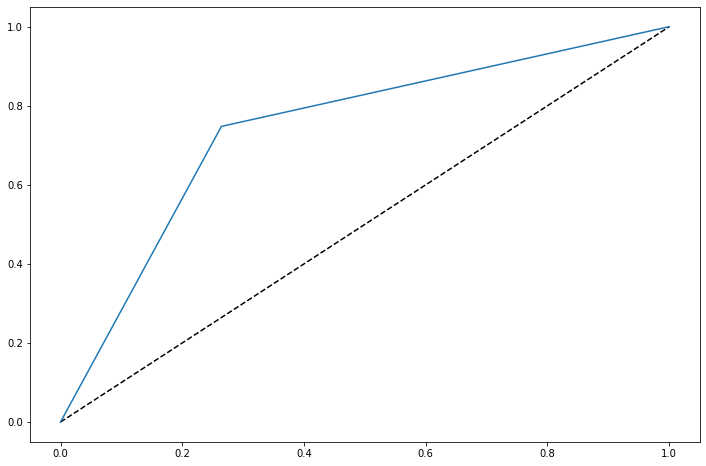

In [162]:
fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(1,1,1)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr)

In [163]:
 print('Accuracy')
print(accuracy_score(y_test, clf_test_pred))
print('Confusion Matrix')
print(confusion_matrix(y_test, clf_test_pred))
print('Confusion Report')
print(classification_report(y_test, clf_test_pred))

Accuracy
0.7387847813742192
Confusion Matrix
[[960 345]
 [115 341]]
Confusion Report
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1305
           1       0.50      0.75      0.60       456

    accuracy                           0.74      1761
   macro avg       0.70      0.74      0.70      1761
weighted avg       0.79      0.74      0.75      1761



### Rpeat the above stats for test data

### saving/loading the model

In [ ]:
joblib.dump(clf, 'RF_F1_.pkl')

In [ ]:
clf_pickle = joblib.load('SVM_test.pkl')